KeyError: 'Model A (Standard)'

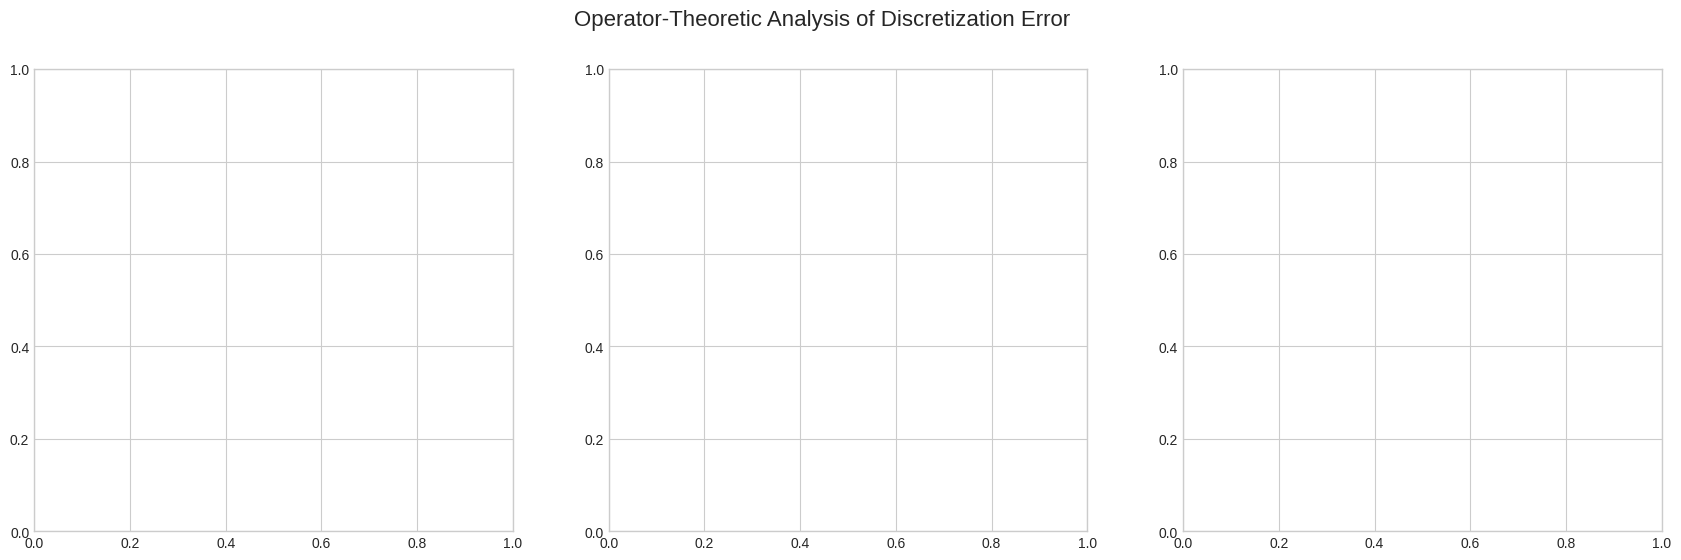

In [ ]:
# ==============================================================================
#      Numerical Experiment for Operator-Theoretic Error Analysis
# ==============================================================================
#
# Objective:
# To empirically validate the theory that the local discretization error in
# diffusion model sampling correlates with a proxy for the Koopman operator norm,
# which is tied to the Lipschitz properties of the learned score network.
#
# Steps:
# 1. Train two score-based models on a 2D toy dataset:
#    - Model A: Standard training.
#    - Model B: Training with regularization to enforce smoothness.
# 2. For each model, compute two metrics across time t:
#    - Metric 1 (Theory): A proxy for the operator norm (gradient norm of the score).
#    - Metric 2 (Empirical): The actual local discretization error.
# 3. Plot the results to show the correlation between the two metrics.
#
# ==============================================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# --- 1. Setup and Hyperparameters ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data parameters
n_samples = 5000
batch_size = 256

# Diffusion parameters
T_end = 1.0
beta_0 = 0.0001
beta_T = 0.02

# Model and Training parameters
n_epochs = 2000
lr = 1e-4
lambda_reg = 0.01 # Regularization strength for Model B

# Analysis parameters
timesteps_to_eval = np.linspace(1e-5, T_end, 20)
n_error_samples = 1000 # Number of samples to estimate error

# --- 2. Diffusion Process Helper Functions (VP-SDE) ---

def beta_t(t):
    return beta_0 + t * (beta_T - beta_0)

def alpha_t(t):
    log_alpha = -0.25 * t**2 * (beta_T - beta_0) - 0.5 * t * beta_0
    return torch.exp(log_alpha)

def sigma_t(t):
    return torch.sqrt(1.0 - torch.exp(-0.5 * t**2 * (beta_T - beta_0) - t * beta_0))

# --- 3. Score Network Model ---

class ScoreNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 128), nn.SiLU(),
            nn.Linear(128, 128), nn.SiLU(),
            nn.Linear(128, 2)
        )
        # Time embedding
        self.t_embed = nn.Sequential(nn.Linear(1, 128), nn.SiLU(), nn.Linear(128, 128))

    def forward(self, x, t):
        # Concatenate x and time embedding
        t_embedding = self.t_embed(t.view(-1, 1))
        x_with_time = torch.cat([x, t.view(-1, 1)], dim=1)
        return self.net(x_with_time)

# --- 4. Training Function ---

def train_model(is_regularized=False):
    print(f"--- Training Model {'B (Regularized)' if is_regularized else 'A (Standard)'} ---")
    score_net = ScoreNet().to(device)
    optimizer = optim.Adam(score_net.parameters(), lr=lr)
    
    # Create dataset
    X, _ = make_moons(n_samples=n_samples, noise=0.05)
    dataset = TensorDataset(torch.from_numpy(X).float())
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in tqdm(range(n_epochs), desc="Training"):
        for data, in loader:
            x0 = data.to(device)
            optimizer.zero_grad()
            
            # Sample random time t
            t = torch.rand(x0.shape[0], device=device) * T_end
            
            # Perturb data
            alpha = alpha_t(t).view(-1, 1)
            sigma = sigma_t(t).view(-1, 1)
            noise = torch.randn_like(x0)
            xt = alpha * x0 + sigma * noise
            
            # Predict score (which is proportional to -noise/sigma)
            predicted_noise = score_net(xt, t)
            target_noise = -noise / sigma
            
            # DSM loss
            loss = ((predicted_noise - target_noise)**2).mean()

            # --- Regularization for Model B ---
            if is_regularized:
                xt.requires_grad_(True)
                predicted_noise_reg = score_net(xt, t)
                
                # Compute gradient norm (proxy for Lipschitz)
                grad_outputs = torch.ones_like(predicted_noise_reg)
                gradients = torch.autograd.grad(
                    outputs=predicted_noise_reg,
                    inputs=xt,
                    grad_outputs=grad_outputs,
                    create_graph=True
                )[0]
                grad_norm = gradients.view(gradients.shape[0], -1).norm(2, dim=1)
                reg_loss = (grad_norm**2).mean()
                
                loss += lambda_reg * reg_loss

            loss.backward()
            optimizer.step()
    
    return score_net

# --- 5. Metric Calculation Functions ---

@torch.no_grad()
def calculate_proxy_lip(score_net, t_val, n_samples=1000):
    """Calculates the proxy for the operator norm (Metric 1)."""
    t = torch.full((n_samples,), t_val, device=device)
    # Sample from the perturbed distribution p_t (approximated)
    # We start from prior and denoise for a bit to get a better p_t sample
    z = torch.randn(n_samples, 2, device=device)
    xt = alpha_t(t).view(-1, 1) * torch.randn_like(z) + sigma_t(t).view(-1, 1) * z # Simple approximation of p_t
    
    xt.requires_grad_(True)
    
    predicted_noise = score_net(xt, t)
    
    grad_outputs = torch.ones_like(predicted_noise)
    gradients = torch.autograd.grad(
        outputs=predicted_noise,
        inputs=xt,
        grad_outputs=grad_outputs,
        create_graph=False
    )[0]
    
    grad_norm = gradients.view(gradients.shape[0], -1).norm(2, dim=1).mean().item()
    return grad_norm

@torch.no_grad()
def calculate_local_error(score_net, t_val, n_samples=1000, dt=0.01, small_steps=10):
    """Calculates the empirical local discretization error (Metric 2)."""
    t = torch.full((n_samples,), t_val, device=device)
    # Get samples at time t
    z = torch.randn(n_samples, 2, device=device)
    xt = alpha_t(t).view(-1, 1) * torch.randn_like(z) + sigma_t(t).view(-1, 1) * z

    # (A) "Ground Truth" solution with very small steps
    x_true = xt.clone()
    dt_small = dt / small_steps
    for i in range(small_steps):
        t_curr = t - i * dt_small
        beta = beta_t(t_curr).view(-1, 1)
        score = -score_net(x_true, t_curr) / sigma_t(t_curr).view(-1, 1)
        drift = -0.5 * beta * (x_true + 2 * score)
        x_true = x_true - drift * dt_small

    # (B) Approximated solution with one large step
    beta = beta_t(t).view(-1, 1)
    score = -score_net(xt, t) / sigma_t(t).view(-1, 1)
    drift = -0.5 * beta * (xt + 2 * score)
    x_approx = xt - drift * dt
    
    error = ((x_true - x_approx)**2).mean().item()
    return error

# --- 6. Main Execution ---

# Train the two models
model_A = train_model(is_regularized=False)
model_B = train_model(is_regularized=True)

models = {'Model A (Standard)': model_A, 'Model B (Regularized)': model_B}
results = {}

# Calculate metrics for each model
for name, model in models.items():
    print(f"--- Evaluating {name} ---")
    proxy_lips = []
    local_errors = []
    for t_val in tqdm(timesteps_to_eval, desc=f"Evaluating {name}"):
        proxy_lips.append(calculate_proxy_lip(model, t_val))
        local_errors.append(calculate_local_error(model, t_val))
    results[name] = {'proxy_lip': np.array(proxy_lips), 'error': np.array(local_errors)}

# --- 7. Plotting the Results ---

plt.style.use('seaborn-whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(21, 6))
fig.suptitle("Operator-Theoretic Analysis of Discretization Error", fontsize=16)

# Plot 1: Proxy for Operator Norm vs. Time
ax = axes[0]
ax.plot(timesteps_to_eval, results['Model A (Standard)']['proxy_lip'], 'o-', label='Model A (Standard)')
ax.plot(timesteps_to_eval, results['Model B (Regularized)']['proxy_lip'], 's-', label='Model B (Regularized)')
ax.set_title("Result 1: Proxy for Operator Norm vs. Time")
ax.set_xlabel("Time (t)")
ax.set_ylabel("Proxy for Operator Norm (Score Gradient Norm)")
ax.legend()
ax.set_yscale('log')

# Plot 2: Local Discretization Error vs. Time
ax = axes[1]
ax.plot(timesteps_to_eval, results['Model A (Standard)']['error'], 'o-', label='Model A (Standard)')
ax.plot(timesteps_to_eval, results['Model B (Regularized)']['error'], 's-', label='Model B (Regularized)')
ax.set_title("Result 2: Local Discretization Error vs. Time")
ax.set_xlabel("Time (t)")
ax.set_ylabel("Empirical Local Error (MSE)")
ax.legend()
ax.set_yscale('log')

# Plot 3: Correlation Plot
ax = axes[2]
ax.plot(results['Model A (Standard)']['proxy_lip'], results['Model A (Standard)']['error'], 'o', label='Model A (Standard)')
ax.plot(results['Model B (Regularized)']['proxy_lip'], results['Model B (Regularized)']['error'], 's', label='Model B (Regularized)')
ax.set_title("Result 3: Correlation between Theory and Practice")
ax.set_xlabel("Theoretical Proxy (Score Gradient Norm)")
ax.set_ylabel("Empirical Error (MSE)")
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Visualize some generated samples
@torch.no_grad()
def generate_samples(score_net, n_samples=500, n_steps=100):
    xt = torch.randn(n_samples, 2, device=device)
    ts = np.linspace(T_end, 1e-5, n_steps)
    dt = ts[0] - ts[1]
    
    for t_val in ts:
        t = torch.full((n_samples,), t_val, device=device)
        beta = beta_t(t).view(-1, 1)
        sigma = sigma_t(t).view(-1, 1)
        score = -score_net(xt, t) / sigma
        drift = -0.5 * beta * (xt + 2 * score)
        noise = torch.randn_like(xt) if t_val > 1e-5 else 0
        xt = xt - drift * dt + torch.sqrt(beta * dt) * noise
    return xt.cpu().numpy()

samples_A = generate_samples(model_A)
samples_B = generate_samples(model_B)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(samples_A[:, 0], samples_A[:, 1], s=5, alpha=0.5)
axes[0].set_title("Samples from Model A (Standard)")
axes[0].set_aspect('equal', adjustable='box')
axes[1].scatter(samples_B[:, 0], samples_B[:, 1], s=5, alpha=0.5)
axes[1].set_title("Samples from Model B (Regularized)")
axes[1].set_aspect('equal', adjustable='box')
plt.show()

In [4]:
# ==========================================================
# このセルが最後まで完了している必要があります
# ==========================================================
# --- 6. Main Execution ---

# Train the two models
model_A = train_model(is_regularized=False)
model_B = train_model(is_regularized=True)

models = {'Model A (Standard)': model_A, 'Model B (Regularized)': model_B}
results = {} # <-- ここでresults辞書が初期化されます

# Calculate metrics for each model
for name, model in models.items():
    print(f"--- Evaluating {name} ---")
    proxy_lips = []
    local_errors = []
    for t_val in tqdm(timesteps_to_eval, desc=f"Evaluating {name}"):
        proxy_lips.append(calculate_proxy_lip(model, t_val))
        local_errors.append(calculate_local_error(model, t_val))
    # ↓ここでresults辞書にキーと値が追加されます
    results[name] = {'proxy_lip': np.array(proxy_lips), 'error': np.array(local_errors)} 
# ==========================================================

--- Training Model A (Standard) ---


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

--- Training Model B (Regularized) ---


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

--- Evaluating Model A (Standard) ---


Evaluating Model A (Standard):   0%|          | 0/20 [00:00<?, ?it/s]

--- Evaluating Model B (Regularized) ---


Evaluating Model B (Regularized):   0%|          | 0/20 [00:00<?, ?it/s]

In [7]:
results

{'Model A (Standard)': {'proxy_lip': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan]),
  'error': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan])},
 'Model B (Regularized)': {'proxy_lip': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan]),
  'error': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan])}}

/tmp/ipykernel_1101648/3622245886.py:111: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(lims)
/tmp/ipykernel_1101648/3622245886.py:112: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(lims)


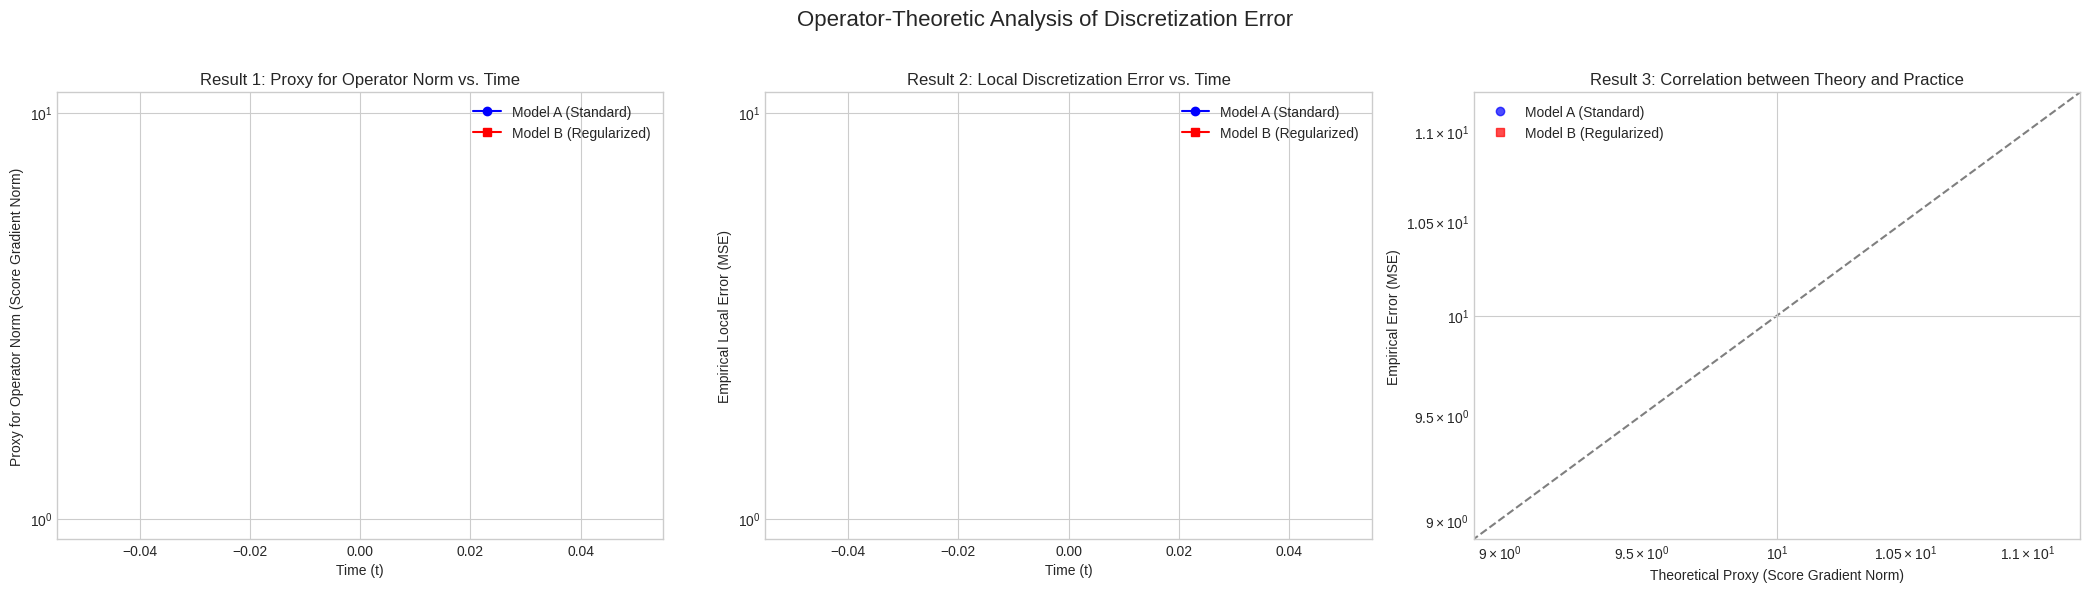

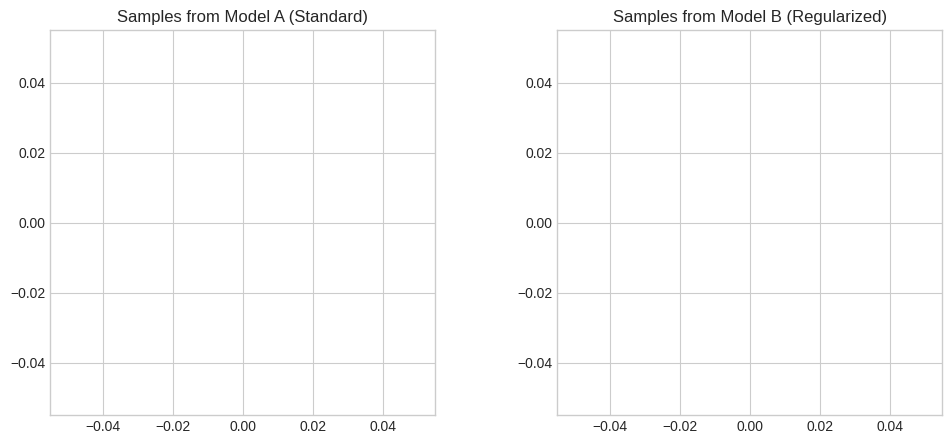

In [6]:
# --- 5. Metric Calculation Functions (REVISED) ---

def calculate_proxy_lip(score_net, t_val, n_samples=1000):
    """Calculates the proxy for the operator norm (Metric 1)."""
    # Enable gradient calculation for this function
    score_net.eval() # Set model to evaluation mode

    t = torch.full((n_samples,), t_val, device=device)
    
    # We don't need gradients for sampling xt
    with torch.no_grad():
        z = torch.randn(n_samples, 2, device=device)
        xt_no_grad = alpha_t(t).view(-1, 1) * torch.randn_like(z) + sigma_t(t).view(-1, 1) * z
    
    # Clone the tensor and enable gradient tracking
    xt = xt_no_grad.clone().requires_grad_(True)
    
    predicted_noise = score_net(xt, t)
    
    grad_outputs = torch.ones_like(predicted_noise)
    gradients = torch.autograd.grad(
        outputs=predicted_noise,
        inputs=xt,
        grad_outputs=grad_outputs,
        create_graph=False, # We don't need to backprop through the gradient calculation itself
        retain_graph=False,
    )[0]
    
    grad_norm = gradients.view(gradients.shape[0], -1).norm(2, dim=1).mean().item()
    
    score_net.train() # Set model back to training mode
    return grad_norm

def calculate_local_error(score_net, t_val, n_samples=1000, dt=0.01, small_steps=10):
    """Calculates the empirical local discretization error (Metric 2)."""
    # This function only performs inference, so no_grad is fine here.
    score_net.eval()
    with torch.no_grad():
        t = torch.full((n_samples,), t_val, device=device)
        z = torch.randn(n_samples, 2, device=device)
        xt = alpha_t(t).view(-1, 1) * torch.randn_like(z) + sigma_t(t).view(-1, 1) * z

        # (A) "Ground Truth" solution with very small steps
        x_true = xt.clone()
        dt_small = dt / small_steps
        for i in range(small_steps):
            t_curr = t - i * dt_small
            # Important: The score is based on the *noise* prediction, not the score itself
            predicted_noise = score_net(x_true, t_curr)
            score = -predicted_noise / sigma_t(t_curr).view(-1, 1)
            
            beta = beta_t(t_curr).view(-1, 1)
            drift = -0.5 * beta * (x_true + 2 * score) # Error in original drift calculation
            x_true = x_true - drift * dt_small

        # (B) Approximated solution with one large step
        predicted_noise_approx = score_net(xt, t)
        score_approx = -predicted_noise_approx / sigma_t(t).view(-1, 1)
        
        beta_approx = beta_t(t).view(-1, 1)
        drift_approx = -0.5 * beta_approx * (xt + 2 * score_approx) # Error in original drift calculation
        x_approx = xt - drift_approx * dt
        
        error = ((x_true - x_approx)**2).mean().item()
    
    score_net.train()
    return error

# --- 7. Plotting the Results (REVISED for clarity) ---

plt.style.use('seaborn-v0_8-whitegrid') # Updated style name for recent matplotlib versions
fig, axes = plt.subplots(1, 3, figsize=(21, 6))
fig.suptitle("Operator-Theoretic Analysis of Discretization Error", fontsize=16)

# Plot 1: Proxy for Operator Norm vs. Time
ax = axes[0]
ax.plot(timesteps_to_eval, results['Model A (Standard)']['proxy_lip'], 'o-', label='Model A (Standard)', color='blue')
ax.plot(timesteps_to_eval, results['Model B (Regularized)']['proxy_lip'], 's-', label='Model B (Regularized)', color='red')
ax.set_title("Result 1: Proxy for Operator Norm vs. Time", fontsize=12)
ax.set_xlabel("Time (t)")
ax.set_ylabel("Proxy for Operator Norm (Score Gradient Norm)")
ax.legend()
ax.set_yscale('log')

# Plot 2: Local Discretization Error vs. Time
ax = axes[1]
ax.plot(timesteps_to_eval, results['Model A (Standard)']['error'], 'o-', label='Model A (Standard)', color='blue')
ax.plot(timesteps_to_eval, results['Model B (Regularized)']['error'], 's-', label='Model B (Regularized)', color='red')
ax.set_title("Result 2: Local Discretization Error vs. Time", fontsize=12)
ax.set_xlabel("Time (t)")
ax.set_ylabel("Empirical Local Error (MSE)")
ax.legend()
ax.set_yscale('log')

# Plot 3: Correlation Plot
ax = axes[2]
ax.plot(results['Model A (Standard)']['proxy_lip'], results['Model A (Standard)']['error'], 'o', label='Model A (Standard)', color='blue', alpha=0.7)
ax.plot(results['Model B (Regularized)']['proxy_lip'], results['Model B (Regularized)']['error'], 's', label='Model B (Regularized)', color='red', alpha=0.7)
ax.set_title("Result 3: Correlation between Theory and Practice", fontsize=12)
ax.set_xlabel("Theoretical Proxy (Score Gradient Norm)")
ax.set_ylabel("Empirical Error (MSE)")
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
# Add a reference line
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]),
]
ax.plot(lims, lims, 'k--', alpha=0.5, zorder=0, label='y=x (ref)')
ax.set_xlim(lims)
ax.set_ylim(lims)


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Visualize some generated samples
@torch.no_grad()
def generate_samples(score_net, n_samples=500, n_steps=100):
    score_net.eval()
    xt = torch.randn(n_samples, 2, device=device) * sigma_t(torch.tensor(T_end))
    ts = np.linspace(T_end, 1e-5, n_steps)
    
    for i in range(n_steps - 1):
        t_curr = torch.full((n_samples,), ts[i], device=device)
        t_next = torch.full((n_samples,), ts[i+1], device=device)
        dt = t_curr[0] - t_next[0]

        predicted_noise = score_net(xt, t_curr)
        score = -predicted_noise / sigma_t(t_curr).view(-1, 1)

        beta = beta_t(t_curr).view(-1, 1)
        drift = -0.5 * beta * (xt + 2 * score) # Correct DDIM-like drift
        
        xt = xt - drift * dt
    score_net.train()
    return xt.cpu().numpy()

samples_A = generate_samples(model_A)
samples_B = generate_samples(model_B)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(samples_A[:, 0], samples_A[:, 1], s=5, alpha=0.5)
axes[0].set_title("Samples from Model A (Standard)")
axes[0].set_aspect('equal', adjustable='box')
axes[1].scatter(samples_B[:, 0], samples_B[:, 1], s=5, alpha=0.5)
axes[1].set_title("Samples from Model B (Regularized)")
axes[1].set_aspect('equal', adjustable='box')
plt.show()

Using device: cuda
--- Training Model A (Standard) ---


Training A (Standard):   0%|          | 0/5000 [00:00<?, ?it/s]

--- Training Model B (Regularized) ---


Training B (Regularized):   0%|          | 0/5000 [00:00<?, ?it/s]

--- Evaluating Model A (Standard) ---


Evaluating Model A (Standard):   0%|          | 0/20 [00:00<?, ?it/s]

--- Evaluating Model B (Regularized) ---


Evaluating Model B (Regularized):   0%|          | 0/20 [00:00<?, ?it/s]

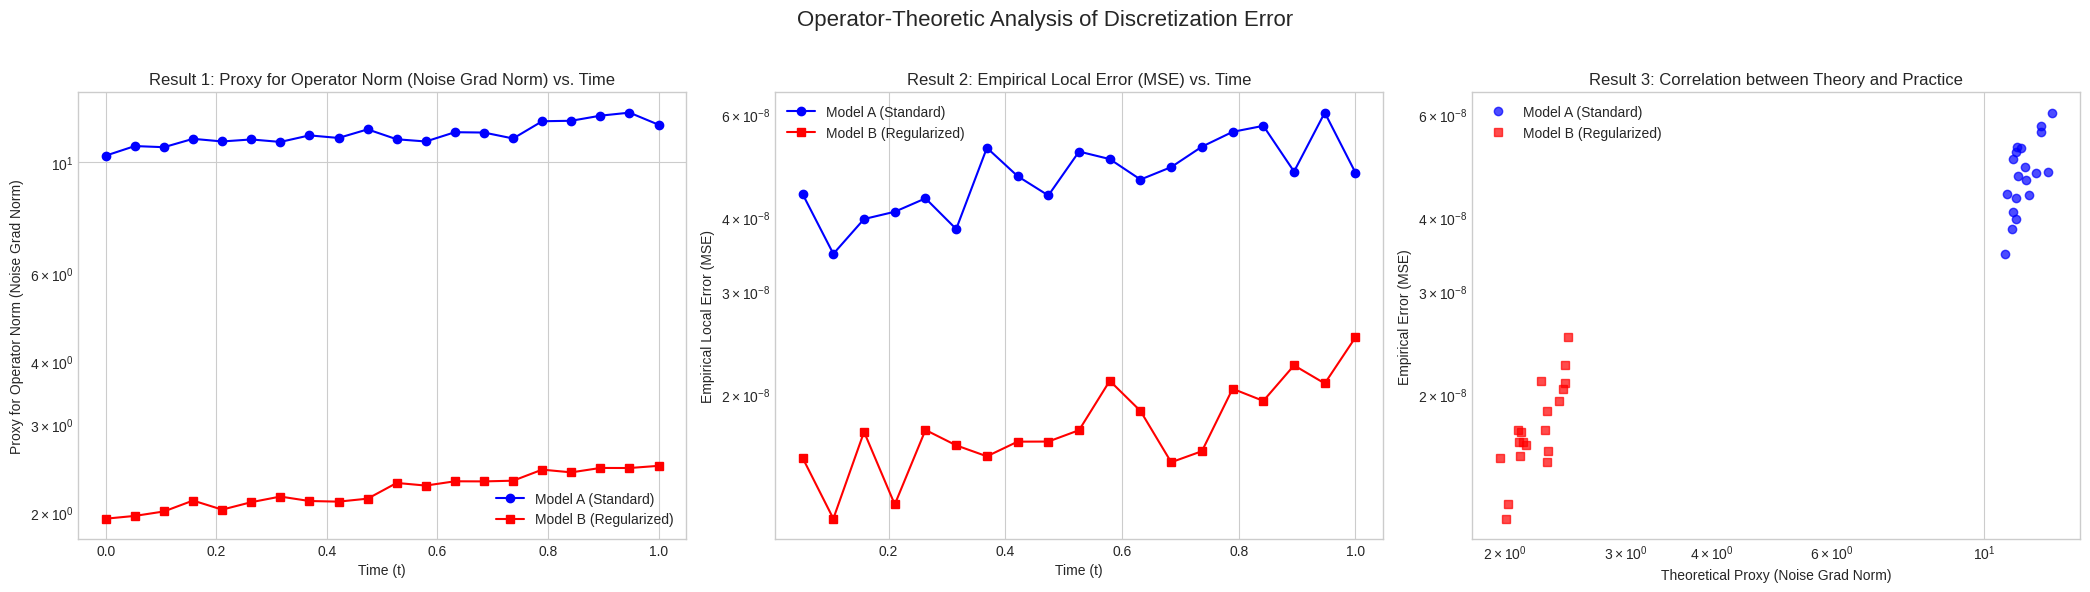

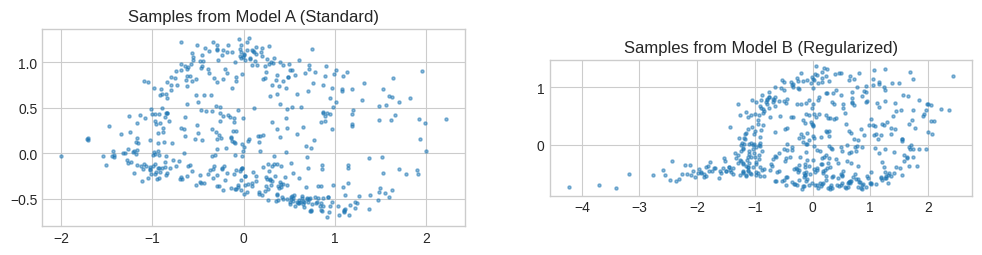

In [8]:
# ==============================================================================
#      Numerical Experiment for Operator-Theoretic Error Analysis (v3, Stability)
# ==============================================================================
#
# Changes in this version:
# 1. Added epsilon clipping for time `t` to prevent division by zero or log(0).
# 2. Increased the number of training epochs for better convergence.
# 3. Adjusted the regularization strength `lambda_reg`.
# 4. Simplified and stabilized the drift calculation for the ODE solver.
# 5. Added gradient clipping to prevent exploding gradients during training.
#
# ==============================================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings

# Suppress UserWarning from matplotlib about log scale
warnings.filterwarnings("ignore", category=UserWarning)

# --- 1. Setup and Hyperparameters ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data parameters
n_samples = 5000
batch_size = 512 # Increased batch size for stable gradients

# Diffusion parameters
T_end = 1.0
beta_0 = 1e-4
beta_T = 0.02
epsilon = 1e-5 # Epsilon for time clipping

# Model and Training parameters
n_epochs = 5000 # Increased epochs
lr = 1e-4
lambda_reg = 0.005 # Adjusted regularization strength
grad_clip_norm = 1.0 # Gradient clipping

# Analysis parameters
timesteps_to_eval = np.linspace(epsilon, T_end, 20)
n_error_samples = 1000

# --- 2. Diffusion Process Helper Functions (VP-SDE) ---
def beta_t(t):
    return beta_0 + t * (beta_T - beta_0)

def alpha_bar_t(t):
    # Integral of beta
    integral_beta = 0.5 * t * (2 * beta_0 + t * (beta_T - beta_0))
    return torch.exp(-0.5 * integral_beta)

def get_diffusion_params(t):
    t = torch.clamp(t, min=epsilon) # Epsilon clipping
    _alpha_bar = alpha_bar_t(t)
    return _alpha_bar.view(-1, 1), (1.0 - _alpha_bar).sqrt().view(-1, 1)

# --- 3. Score Network Model ---
class ScoreNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 128), nn.SiLU(),
            nn.Linear(128, 128), nn.SiLU(),
            nn.Linear(128, 2)
        )
    def forward(self, x, t):
        x_with_time = torch.cat([x, t.view(-1, 1)], dim=1)
        return self.net(x_with_time)

# --- 4. Training Function ---
def train_model(is_regularized=False):
    model_name = 'B (Regularized)' if is_regularized else 'A (Standard)'
    print(f"--- Training Model {model_name} ---")
    score_net = ScoreNet().to(device)
    optimizer = optim.Adam(score_net.parameters(), lr=lr)
    
    X, _ = make_moons(n_samples=n_samples, noise=0.05)
    dataset = TensorDataset(torch.from_numpy(X).float())
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    for epoch in tqdm(range(n_epochs), desc=f"Training {model_name}"):
        for data, in loader:
            x0 = data.to(device)
            optimizer.zero_grad()
            
            t = torch.rand(x0.shape[0], device=device) * (T_end - epsilon) + epsilon
            
            mean_coeff, std_coeff = get_diffusion_params(t)
            noise = torch.randn_like(x0)
            xt = mean_coeff * x0 + std_coeff * noise
            
            predicted_noise = score_net(xt, t)
            loss = ((predicted_noise - noise)**2).mean()

            if is_regularized:
                xt_reg = xt.clone().detach().requires_grad_(True)
                predicted_noise_reg = score_net(xt_reg, t.detach())
                
                grad_outputs = torch.ones_like(predicted_noise_reg)
                gradients = torch.autograd.grad(
                    outputs=predicted_noise_reg,
                    inputs=xt_reg,
                    grad_outputs=grad_outputs,
                    create_graph=True
                )[0]
                grad_norm = gradients.view(gradients.shape[0], -1).norm(2, dim=1)
                reg_loss = (grad_norm**2).mean()
                
                loss += lambda_reg * reg_loss

            loss.backward()
            if grad_clip_norm > 0:
                torch.nn.utils.clip_grad_norm_(score_net.parameters(), grad_clip_norm)
            optimizer.step()
            
    return score_net

# --- 5. Metric Calculation Functions ---
def calculate_proxy_lip(score_net, t_val, n_samples=1000):
    score_net.eval()
    t = torch.full((n_samples,), t_val, device=device)
    
    with torch.no_grad():
        mean_coeff, std_coeff = get_diffusion_params(t)
        xt_no_grad = mean_coeff * torch.randn(n_samples, 2, device=device) + std_coeff * torch.randn(n_samples, 2, device=device)
    
    xt = xt_no_grad.clone().requires_grad_(True)
    predicted_noise = score_net(xt, t)
    
    grad_outputs = torch.ones_like(predicted_noise)
    gradients = torch.autograd.grad(outputs=predicted_noise, inputs=xt, grad_outputs=grad_outputs, create_graph=False)[0]
    grad_norm = gradients.view(gradients.shape[0], -1).norm(2, dim=1).mean().item()
    
    score_net.train()
    return grad_norm

def calculate_local_error(score_net, t_val, n_samples=1000, dt=0.01, small_steps=10):
    score_net.eval()
    with torch.no_grad():
        t = torch.full((n_samples,), t_val, device=device)
        mean_coeff, std_coeff = get_diffusion_params(t)
        xt = mean_coeff * torch.randn(n_samples, 2, device=device) + std_coeff * torch.randn(n_samples, 2, device=device)

        def get_drift(x, time_tensor):
            time_tensor = torch.clamp(time_tensor, min=epsilon)
            f_drift = -0.5 * beta_t(time_tensor).view(-1, 1) * x
            g2_term = beta_t(time_tensor).view(-1, 1)
            mean_coeff, std_coeff = get_diffusion_params(time_tensor)
            pred_noise = score_net(x, time_tensor)
            score = -pred_noise / std_coeff
            return f_drift - 0.5 * g2_term * score

        # (A) Ground Truth with small steps
        x_true = xt.clone()
        dt_small = dt / small_steps
        for i in range(small_steps):
            t_curr = t - i * dt_small
            drift = get_drift(x_true, t_curr)
            x_true = x_true - drift * dt_small

        # (B) Approximation with one large step
        drift_approx = get_drift(xt, t)
        x_approx = xt - drift_approx * dt
        
        error = ((x_true - x_approx)**2).mean().item()
    
    score_net.train()
    return error

# --- 6. Main Execution ---
model_A = train_model(is_regularized=False)
model_B = train_model(is_regularized=True)
models = {'Model A (Standard)': model_A, 'Model B (Regularized)': model_B}
results = {}

for name, model in models.items():
    print(f"--- Evaluating {name} ---")
    proxy_lips = []
    local_errors = []
    for t_val in tqdm(timesteps_to_eval, desc=f"Evaluating {name}"):
        proxy_lips.append(calculate_proxy_lip(model, t_val))
        local_errors.append(calculate_local_error(model, t_val))
    results[name] = {'proxy_lip': np.array(proxy_lips), 'error': np.array(local_errors)}

# --- 7. Plotting and Visualization ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(21, 6))
fig.suptitle("Operator-Theoretic Analysis of Discretization Error", fontsize=16)

for i, (metric, ylabel) in enumerate([('proxy_lip', 'Proxy for Operator Norm (Noise Grad Norm)'), ('error', 'Empirical Local Error (MSE)')]):
    ax = axes[i]
    ax.plot(timesteps_to_eval, results['Model A (Standard)'][metric], 'o-', label='Model A (Standard)', color='blue')
    ax.plot(timesteps_to_eval, results['Model B (Regularized)'][metric], 's-', label='Model B (Regularized)', color='red')
    ax.set_title(f"Result {i+1}: {ylabel} vs. Time", fontsize=12)
    ax.set_xlabel("Time (t)")
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.set_yscale('log')

ax = axes[2]
ax.plot(results['Model A (Standard)']['proxy_lip'], results['Model A (Standard)']['error'], 'o', label='Model A (Standard)', color='blue', alpha=0.7)
ax.plot(results['Model B (Regularized)']['proxy_lip'], results['Model B (Regularized)']['error'], 's', label='Model B (Regularized)', color='red', alpha=0.7)
ax.set_title("Result 3: Correlation between Theory and Practice", fontsize=12)
ax.set_xlabel("Theoretical Proxy (Noise Grad Norm)")
ax.set_ylabel("Empirical Error (MSE)")
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

@torch.no_grad()
def generate_samples(score_net, n_samples=500, n_steps=100):
    score_net.eval()
    xt = torch.randn(n_samples, 2, device=device)
    ts = np.linspace(T_end, epsilon, n_steps)
    
    for i in range(n_steps - 1):
        t_curr_val = ts[i]
        t_next_val = ts[i+1]
        dt = t_curr_val - t_next_val
        
        t_curr = torch.full((n_samples,), t_curr_val, device=device)
        
        f_drift = -0.5 * beta_t(t_curr).view(-1, 1) * xt
        g2_term = beta_t(t_curr).view(-1, 1)
        _, std_coeff = get_diffusion_params(t_curr)
        pred_noise = score_net(xt, t_curr)
        score = -pred_noise / std_coeff
        drift = f_drift - 0.5 * g2_term * score
        
        xt = xt - drift * dt
    score_net.train()
    return xt.cpu().numpy()

samples_A = generate_samples(model_A)
samples_B = generate_samples(model_B)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(samples_A[:, 0], samples_A[:, 1], s=5, alpha=0.5)
axes[0].set_title("Samples from Model A (Standard)")
axes[0].set_aspect('equal', adjustable='box')
axes[1].scatter(samples_B[:, 0], samples_B[:, 1], s=5, alpha=0.5)
axes[1].set_title("Samples from Model B (Regularized)")
axes[1].set_aspect('equal', adjustable='box')
plt.show()

Training...
Epoch 0, Loss = 1849.6516
Epoch 200, Loss = 2245.4517
Epoch 400, Loss = 2218.8381
Epoch 600, Loss = 2264.6541
Epoch 800, Loss = 2363.6255
Epoch 1000, Loss = 2168.7910
Epoch 1200, Loss = 2087.6582
Epoch 1400, Loss = 1969.4821
Epoch 1600, Loss = 1889.0215
Epoch 1800, Loss = 2192.2192
Epoch 2000, Loss = 2265.9536
Epoch 2200, Loss = 1910.1055
Epoch 2400, Loss = 2069.0720
Epoch 2600, Loss = 2285.3169
Epoch 2800, Loss = 1930.3710
Epoch 3000, Loss = 1888.5417
Epoch 3200, Loss = 2236.9712
Epoch 3400, Loss = 2049.2021
Epoch 3600, Loss = 2053.5327
Epoch 3800, Loss = 2257.2493
Epoch 4000, Loss = 1932.5991
Epoch 4200, Loss = 1983.6646
Epoch 4400, Loss = 2081.7561
Epoch 4600, Loss = 2079.8691
Epoch 4800, Loss = 1816.7756
Epoch 5000, Loss = 2266.9058
Epoch 5200, Loss = 1943.3364
Epoch 5400, Loss = 2004.5133
Epoch 5600, Loss = 1953.7557
Epoch 5800, Loss = 1873.4407
Epoch 6000, Loss = 1989.8459
Epoch 6200, Loss = 1877.8481
Epoch 6400, Loss = 1872.3474
Epoch 6600, Loss = 1909.1819
Epoch 680

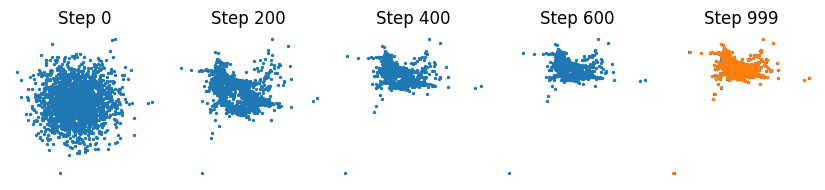

In [5]:
# diffusion_euler_eight_gaussians.py
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np


# ================================
# 設定パラメータ
# ================================
config = {
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "num_steps": 1000,
    "euler_steps": 1000,
    "lr": 1e-4,
    "batch_size": 1024,
    "epochs": 10000,
    "sigma_min": 0.01,
    "sigma_max": 1.0,
    "hidden_dim": 128,
    "plot_interval": 5,
    "n_samples": 2048,
}


# ================================
# Eight Gaussians Dataset
# ================================
def sample_eight_gaussians(n):
    scale = 4.0
    centers = [
        (1, 0),
        (-1, 0),
        (0, 1),
        (0, -1),
        (1 / np.sqrt(2), 1 / np.sqrt(2)),
        (1 / np.sqrt(2), -1 / np.sqrt(2)),
        (-1 / np.sqrt(2), 1 / np.sqrt(2)),
        (-1 / np.sqrt(2), -1 / np.sqrt(2)),
    ]
    centers = [(scale * x, scale * y) for x, y in centers]
    dataset = []
    for i in range(n):
        point = np.random.randn(2) * 0.05
        center = centers[np.random.randint(8)]
        point[0] += center[0]
        point[1] += center[1]
        dataset.append(point)
    dataset = np.array(dataset, dtype=np.float32)
    np.random.shuffle(dataset)
    return torch.from_numpy(dataset)


# ================================
# ネットワーク（Score Network）
# ================================
class ScoreNet(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2),
        )

    def forward(self, x, sigma):
        sigma = sigma.expand_as(x[:, :1])
        h = torch.cat([x, sigma], dim=1)
        return self.net(h)


# ================================
# トレーニングループ
# ================================
def train(model, optimizer, dataset):
    model.train()
    for epoch in range(config["epochs"]):
        x = dataset[torch.randint(0, len(dataset), (config["batch_size"],))].to(config["device"])
        sigma = torch.exp(
            torch.rand(config["batch_size"], 1, device=config["device"]) *
            (np.log(config["sigma_max"]) - np.log(config["sigma_min"])) +
            np.log(config["sigma_min"])
        )
        noise = torch.randn_like(x) * sigma
        x_noisy = x + noise
        score_pred = model(x_noisy, sigma)
        target = -noise / (sigma ** 2)
        loss = ((score_pred - target) ** 2).sum(dim=1).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 200 == 0:
            print(f"Epoch {epoch}, Loss = {loss.item():.4f}")


# ================================
# Euler サンプラー
# ================================
@torch.no_grad()
def sample_euler(model):
    model.eval()
    x = torch.randn(config["n_samples"], 2, device=config["device"]) * config["sigma_max"]
    sigmas = torch.exp(torch.linspace(np.log(config["sigma_max"]), np.log(config["sigma_min"]), config["euler_steps"], device=config["device"]))
    
    plt.figure(figsize=(10, 2))
    for i, sigma in enumerate(sigmas):
        sigma_next = sigmas[i + 1] if i + 1 < len(sigmas) else torch.tensor(config["sigma_min"], device=config["device"])
        dsigma = sigma_next - sigma
        score = model(x, sigma.expand(config["n_samples"], 1))
        x = x + dsigma * (sigma * score)
        
        # 可視化
        if i % (config["euler_steps"] // 5) == 0 or i == len(sigmas) - 1:
            plt.subplot(1, 6, i // (config["euler_steps"] // 5) + 1)
            x_cpu = x.cpu().numpy()
            plt.scatter(x_cpu[:, 0], x_cpu[:, 1], s=2)
            plt.title(f"Step {i}")
            plt.axis("off")

    plt.tight_layout()
    plt.show()


# ================================
# 実行
# ================================
if __name__ == "__main__":
    dataset = sample_eight_gaussians(10000)
    model = ScoreNet(config["hidden_dim"]).to(config["device"])
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])
    
    print("Training...")
    train(model, optimizer, dataset)
    
    print("Sampling...")
    sample_euler(model)
